In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$- \Delta u  + u = f, \text{ in } \Omega$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

![basis_6](basis_6.png)

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

![base_3.png](attachment: base_3.png)

![base_3_prime.png](base_3_prime.png)

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p [v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p)] w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Auxiliary functions

In [3]:
import numpy as np
from scipy import interpolate, integrate, linalg
import time

### Standard basis vectors

In [4]:
def std_vectors(n):
    '''Returns standard basis in R^n'''
    return np.array([[1. if i == j else 0. for i in range(n)] for j in range(n)])


### One dimensional Lagrange basis

In [5]:
def lagrange_one_d(n):
    '''Returns Lagrange basis functions and derivative in one dimension'''
    # define standard basis and points
    E = std_vectors(n)
    X = np.polynomial.chebyshev.chebpts2(n)
    # construct basis
    B = [interpolate.lagrange(X, E[i]) for i in range(n)]
    # return basis and derivatives
    return B, [np.polyder(B[i]) for i in range(n)]       

### Two dimensional Lagrange basis

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [6]:
def compute_one_dimensional_matrices(n):
    '''Computes matrices stifness matrix K, mass matrix M and system matrix A for 1-D problem '''
    # compute quadrature points and weights
    q, w = np.polynomial.legendre.leggauss(n+1)
    # construct lagrange basis functions and their derivatives
    B_lagrange, B_lagrange_prime = lagrange_one_d(n)
    # build B and D matrices
    B = np.array([[B_lagrange[i](q[alpha]) for alpha in range(len(q))] for i in range(len(B_lagrange))])
    D = np.array([[B_lagrange_prime[i](q[alpha]) for alpha in range(len(q))] for i in range(len(B_lagrange_prime))])
    # build stiffness, mass and system matrices
    K = np.einsum('iq, q, jq', D, w, D)
    M = np.einsum('iq, q, jq', B, w, B)
    A = K + M

    return K, M, A

#### Trials

In [7]:
K, M, A = compute_one_dimensional_matrices(6)
print('STIFFNESS MATRIX')
print(K)
print('------')
print('MASS MATRIX')
print(M)
print('------')
print('SYSTEM MATRIX')
print(A)

STIFFNESS MATRIX
[[ 6.38393651 -6.8867901   0.52443735  0.06418693 -0.21154846  0.12577778]
 [-6.8867901   9.88719156 -3.28736508  0.19098413  0.30752795 -0.21154846]
 [ 0.52443735 -3.28736508  5.06239574 -2.55463906  0.19098413  0.06418693]
 [ 0.06418693  0.19098413 -2.55463906  5.06239574 -3.28736508  0.52443735]
 [-0.21154846  0.30752795  0.19098413 -3.28736508  9.88719156 -6.8867901 ]
 [ 0.12577778 -0.21154846  0.06418693  0.52443735 -6.8867901   6.38393651]]
------
MASS MATRIX
[[ 0.06139105 -0.01972348 -0.01192348  0.02457196 -0.02441707  0.01010101]
 [-0.01972348  0.36188325  0.04802309 -0.06427706  0.0592543  -0.02441707]
 [-0.01192348  0.04802309  0.52543565  0.07742679 -0.06427706  0.02457196]
 [ 0.02457196 -0.06427706  0.07742679  0.52543565  0.04802309 -0.01192348]
 [-0.02441707  0.0592543  -0.06427706  0.04802309  0.36188325 -0.01972348]
 [ 0.01010101 -0.02441707  0.02457196 -0.01192348 -0.01972348  0.06139105]]
------
SYSTEM MATRIX
[[ 6.44532756 -6.90651358  0.51251386  0.

### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

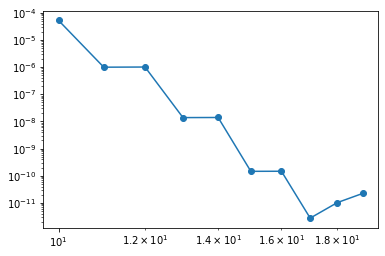

In [8]:
def exact_one_d(x):
    '''Computes exact solution at point x'''
    return np.cos(np.pi*x)
    
def rhs_one_d(x):
    '''Computes forcing term at point x'''
    return (1.+np.pi**2)*np.cos(np.pi*x)

def solve_one_d(n, forcing_term=rhs_one_d):
    '''Solve linear system Au = f'''
    # compute quadrature points and weights
    q, w = np.polynomial.legendre.leggauss(n)
    # build system matrix    
    _ ,_ ,A = compute_one_dimensional_matrices(n)
    # build forcing term vector
    B_lagrange, _ = lagrange_one_d(n)
    f = np.array([np.sum(b(q)*forcing_term(q)*w) for b in B_lagrange])
    # solve system Au = f
    # u = np.linalg.solve(A,f)
    u = linalg.solve(A, f, sym_pos=True)
    return u

def solution_one_d(x, u, basis):
    '''Evaluate solution u of linear system Au = f at given x points using basis'''
    # compute basis
    basis_x = np.array([b(x) for b in basis])
    return np.sum(basis_x*u)

def compute_error_one_d(n, exact, rhs):
    '''Computes error'''
    # solve system
    u = solve_one_d(n)
    # construct basis
    B_lagrange, _ = lagrange_one_d(n)
    # define error as function of point x
    error_fn = lambda x: (solution_one_d(x, u, B_lagrange) - exact_one_d(x))**2
    # compute total error
    error = integrate.quad(error_fn, -1, 1)[0]
    return np.sqrt(error)

error = []
all_n = range(10,20)
for n in all_n:
    error.append(compute_error_one_d(n, exact_one_d, rhs_one_d))

loglog(all_n, error, 'o-')

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [9]:
def compute_two_dimensional_matrices(n):
    '''Computes matrices stifness matrix K, mass matrix M and system matrix A for 2-D problem '''
    # build one dimensional matrices 
    K, M, _ = compute_one_dimensional_matrices(n)
    # use one dimensional matrices to build two dimensional matrices
    KM = np.einsum('ik, jl -> ijkl', K, M)
    MK = np.einsum('ik, jl -> ijkl', M, K)
    MM = np.einsum('ik, jl -> ijkl', M, M)
    KK = KM + MK
    AA = KK + MM 
    # reshape matrices to get two-indexed matrices
    return KK.reshape((n**2,n**2)), MM.reshape((n**2,n**2)), AA.reshape((n**2,n**2))

#### Trials

In [10]:
KK, MM, AA = compute_two_dimensional_matrices(2)

print('SYSTEM MATRIX')
print(AA)

SYSTEM MATRIX
[[ 1.11111111  0.05555556  0.05555556 -0.22222222]
 [ 0.05555556  1.11111111 -0.22222222  0.05555556]
 [ 0.05555556 -0.22222222  1.11111111  0.05555556]
 [-0.22222222  0.05555556  0.05555556  1.11111111]]


### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

![exact_2d.png](attachment:exact_2d.png)

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [11]:
def exact_two_d(x, y):
    '''Computes exact solution at point (x,y)'''
    return np.cos(np.pi*x)*np.cos(np.pi*y)

def rhs_two_d(x, y):
    '''Computes forcing term at point (x,y)'''
    try:
        return (1.+2.*np.pi**2)*np.cos(np.pi*x).reshape((len(x),-1))*np.cos(np.pi*y)
    except TypeError:
        return (1.+2.*np.pi**2)*np.cos(np.pi*x)*np.cos(np.pi*y)

def solve_two_d(n, forcing_term=rhs_two_d):
    '''Computes solution of 2-D problem'''
    # compute quadrature points and weights
    q, w = np.polynomial.legendre.leggauss(n)
    W = w.reshape((len(w),-1))*w
    # build system matrix    
    _, _, AA = compute_two_dimensional_matrices(n)
    # build forcing term array
    B_lagrange, _ = lagrange_one_d(n)
    n_basis_fns = len(B_lagrange)
    f = np.array([[np.sum(bx(q).reshape((n_basis_fns, -1))*by(q)*forcing_term(q,q)*W) for by in B_lagrange] for bx in B_lagrange])
    # solve system Au = f
    # u = np.linalg.solve(A,f)
    u = linalg.solve(AA, f.reshape((n**2)), sym_pos=True)
    return u.reshape((n,n))

def solution_two_d(x, y, u, basis):
    '''Evaluate solution u of linear system Au = f at given (x,y) point using basis'''
    # compute basis
    try:
        basis_x_y = np.array([[bx(x).reshape((len(x),-1))*by(y) for by in basis] for bx in basis])
        return np.einsum('klij, kl -> ij',basis_x_y, u)
    except TypeError:
        basis_x_y = np.array([[bx(x)*by(y) for by in basis] for bx in basis])
        return np.sum(basis_x_y*u) 

def compute_error_two_d(n, exact, rhs):
    '''Computes error'''
    # solve system
    u = solve_two_d(n)
    # construct basis
    B_lagrange, _ = lagrange_one_d(n)
    # define error as function of point x
    error_fn = lambda x, y: (solution_two_d(x, y, u, B_lagrange) - exact_two_d(x, y))**2
    # compute total error
    # define lower and upper boundary curve for two-dimensional integration
    gfun = lambda x: -1
    hfun = lambda x: 1
    error = integrate.dblquad(error_fn, -1, 1, gfun, hfun)[0]
    return np.sqrt(error)

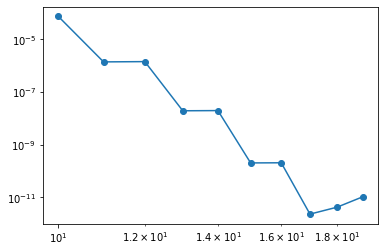

In [12]:
# error behavior
error = []
all_n = range(10,20)
for n in all_n:
    error.append(compute_error_two_d(n, exact_two_d, rhs_two_d))

loglog(all_n, error, 'o-')

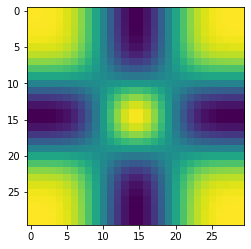

In [13]:
u = solve_two_d(30)
imshow(u)

In [14]:
print(compute_error_two_d(30, exact_two_d, rhs_two_d))

9.969069783314439e-08


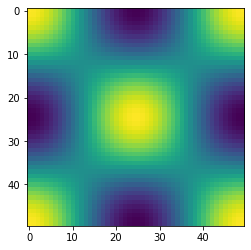

In [15]:
x = np.linspace(-1,1,50)
solution = solution_two_d(x, x, u, lagrange_one_d(30)[0])
imshow(solution)

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [16]:
def cg(matvec, b, x0, matrices, tol=1e-05, maxiter=10000):
    '''Conjugate Gradient method'''
    # recover matrices for matrix multiplication
    K, M = matrices

    # inside this function, you can call matvec(b) to evaluate the matrix vector 
    # set initial point
    x = x0.copy()
    # set number of current iteration
    n_iter = 0
    # compute r vector at step 0
    r = b - matvec(x, K, M)
    # set p
    p = r.copy()
    # normalization for relative error
    norm_relerr = 1/(linalg.norm(b,2))
    # set initial value of tolerance
    eps = linalg.norm(r,2)*norm_relerr

    while n_iter < maxiter and eps > tol:
        # increase identifier for current iteration
        n_iter += 1
        
        # conjugate gradient method procedure
        # use 'matvec' function instead of dot(A,p).
        # Compute this quantity now and once in order to avoid multiple computations of same quantity
        Ap = matvec(p, K, M)
        # v1 @ v2 equivalent to dot(v1,v2)
        a = (p @ r)/(p @ Ap)
        x += a*p
        r -= a*Ap
        b = (Ap @ r)/(Ap @ p)
        p = r - b*p

        # compute ||r||/||b||
        eps = linalg.norm(r,2)*norm_relerr

    # return solution and final value of ratio ||r||/||b||     
    return x, eps

### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

In [17]:
def matvec(vinput, K, M):
    '''Implements the matrix vector product'''
    n = len(K)

    if n != np.sqrt(len(vinput)):
        raise Exception('input vector vinput cannot be reshaped into nxn matrix')
    
    v = vinput.reshape((n,n))
    
    Mv = M@v
    Kv = K@v

    KT_Mv = K@Mv 
    MT_Kv = M@Kv 
    MT_Mv = M@Mv 

    u = K@Mv 
    u += M@Kv 
    u += M@Mv 

    return u.reshape((n**2))

#### Trials: conjugate gradient method

In [18]:
def solve_two_d_cg(n, forcing_term=rhs_two_d, matvec=matvec):
    '''Computes solution using conjugate gradient method'''
    # compute quadrature points and weights
    q, w = np.polynomial.legendre.leggauss(n)
    W = w.reshape((len(w),-1))*w
    # build forcing term array
    B_lagrange, _ = lagrange_one_d(n)
    n_basis_fns = len(B_lagrange)
    f = np.array([[np.sum(bx(q).reshape((n_basis_fns, -1))*by(q)*forcing_term(q,q)*W) for by in B_lagrange] for bx in B_lagrange])
    # build system matrix    
    K, M, _ = compute_one_dimensional_matrices(n)
    matrices = (K,M)
    # find solution through cg function 
    u, eps = cg(matvec, f.reshape((n**2)), np.random.random_sample((n**2)), matrices)

    return u.reshape((n,n)), eps

def compute_error_two_d_cg(n, exact, rhs, matvec=matvec):
    '''Computes error'''
    # solve system
    u, _ = solve_two_d_cg(n)
    # construct basis
    B_lagrange, _ = lagrange_one_d(n)
    # define error as function of point x
    error_fn = lambda x, y: (solution_two_d(x, y, u, B_lagrange) - exact_two_d(x, y))**2
    # compute total error
    # define lower and upper boundary curve for two-dimensional integration
    gfun = lambda x: -1
    hfun = lambda x: 1
    error = integrate.dblquad(error_fn, -1, 1, gfun, hfun)[0]
    return np.sqrt(error)

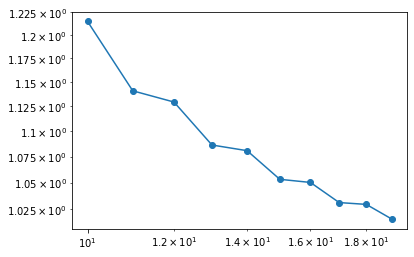

In [19]:
# error behavior
error = []
all_n = range(10,20)
for n in all_n:
    error.append(compute_error_two_d_cg(n, exact_two_d, rhs_two_d))

loglog(all_n, error, 'o-')

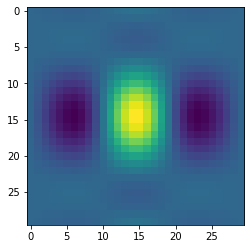

In [20]:
u, eps = solve_two_d_cg(30)
imshow(u)

In [21]:
print(eps)

6.0317854823730935e-06


### Timing

In [22]:
matrix_dims = range(50,101)
time_full = []
time_compressed = []

for n in matrix_dims:

    # build random vector for testing
    x = np.random.random_sample(size=(n**2,))

    # build full system matrix for 2D problem
    _, _, AA = compute_two_dimensional_matrices(n)
    # start timing
    t_start = time.time()
    # perform multiplication by standard method
    _ = AA.dot(x)
    # end timing
    t_end = time.time()
    time_full.append(t_end-t_start)

    # build stiffness and mass matrix for 1D problem
    K, M, _ = compute_one_dimensional_matrices(n)
    # start timing
    t_start = time.time()
    # perform multiplication using matvec function
    _ = matvec(x, K, M)
    # end timing
    t_end = time.time()
    time_compressed.append(t_end-t_start)

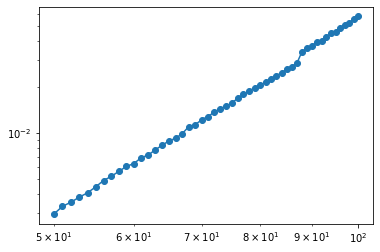

In [23]:
matrix_dims = range(50,101)
delta_t = abs(np.array(time_compressed)-np.array(time_full))
loglog(matrix_dims, delta_t, 'o-', label='absolute time difference')

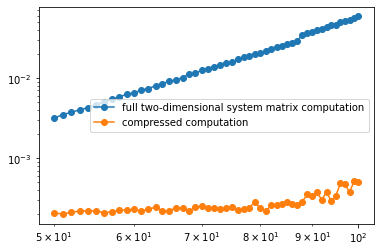

In [24]:
loglog(matrix_dims, time_full, 'o-', label='full two-dimensional system matrix computation')
loglog(matrix_dims, time_compressed, 'o-', label='compressed computation')
legend()

### 6. "Matrix free" evaluation for three dimensional problems (mandatory for MHPC, optional for others)

Looking at https://www.geeksforgeeks.org/running-python-script-on-gpu/, implement the same matrix free solver for three dimensional problems, exploiting just in time compilation, numba, and (optionally) GPU acceleration (if you have access to a GPU). 

Compare the timings you get for a fixed number of matrix vector products as n increases from 50 to 100 for the cases 

1. matrix based (assemble the three dimensional A, measure time of 100 A.dot(v)
2. matrix free, pure numpy (using techinque above, measure time 100 applications of matvec(v))
3. matrix free, numba+jit on CPU (measure time 100 applications of matvec(v))
4. (optional) matrix free, numba+jit on GPU (measure time 100 applications of matvec(v))

Comment on your findings.

In [25]:
# your code here